This only include test set at the very final. Select the model with best MCC

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [3]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [4]:
def prepare_structure_data(df):
    """Enhanced feature preparation with better normalization"""
    
    # Normalize angles to their circular nature
    def normalize_angles(angle_array):
        angle_rad = np.pi * angle_array / 180.0
        return np.stack([np.sin(angle_rad), np.cos(angle_rad)], axis=-1)
    
    # Process each feature type
    features_list = []
    
    # 1. Process angles (phi, psi, omega, tau)
    angles = ['phi', 'psi', 'omega', 'tau']
    for angle in angles:
        # Convert string to array
        angle_arrays = np.array([np.array(eval(x)) for x in df[angle]])
        # Get sin/cos representations
        angle_features = normalize_angles(angle_arrays)
        features_list.append(angle_features)
    
    # 2. Process SASA
    sasa_arrays = np.array([np.array(eval(x)) for x in df['sasa']])
    scaler = RobustScaler()
    sasa_flat = sasa_arrays.reshape(-1, 1)
    sasa_scaled = scaler.fit_transform(sasa_flat).reshape(sasa_arrays.shape)
    features_list.append(sasa_scaled[..., np.newaxis])
    
    # 3. Process secondary structure
    ss_arrays = np.array([list(seq) for seq in df['ss']])
    ss_encoded = np.zeros((len(ss_arrays), ss_arrays.shape[1], 3))
    ss_map = {'H': 0, 'E': 1, 'L': 2}
    for i in range(len(ss_arrays)):
        for j in range(len(ss_arrays[i])):
            ss_encoded[i, j, ss_map[ss_arrays[i, j]]] = 1
    features_list.append(ss_encoded)
    
    # Combine all features
    features = np.concatenate(features_list, axis=-1)
    
    return features

In [ ]:
def create_combined_model(seq_length=33, struct_features=12, struct_window=0):
    """Create model with both sequence and structure tracks
    
    Args:
        seq_length: length of the input sequence
        struct_features: number of structural features
        struct_window: number of positions to use around middle (0 = only middle position)
    """
    # Calculate actual window size for structure
    struct_positions = 1 + (2 * struct_window)  # center + window on each side
    middle_pos = seq_length // 2
    
    # Sequence track
    seq_input = tf.keras.layers.Input(shape=(seq_length,), name='sequence_input')
    x_seq = tf.keras.layers.Embedding(21, 21, input_length=seq_length)(seq_input)
    x_seq = tf.keras.layers.Reshape((seq_length, 21, 1))(x_seq)
    x_seq = tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid')(x_seq)
    x_seq = tf.keras.layers.Dropout(0.2)(x_seq)
    x_seq = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_seq)
    x_seq = tf.keras.layers.Flatten()(x_seq)
    x_seq = tf.keras.layers.Dense(32, activation='relu')(x_seq)
    x_seq = tf.keras.layers.Dropout(0.2)(x_seq)
    
    # Structure track
    struct_input = tf.keras.layers.Input(shape=(seq_length, struct_features), name='structure_input')
    
    # Extract window around middle position
    if struct_window == 0:
        # Use only middle position
        x_struct = tf.keras.layers.Lambda(
            lambda x: x[:, middle_pos:middle_pos+1, :]
        )(struct_input)
    else:
        # Use window around middle position
        x_struct = tf.keras.layers.Lambda(
            lambda x: x[:, middle_pos-struct_window:middle_pos+struct_window+1, :]
        )(struct_input)
    
    x_struct = tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu')(x_struct)
    x_struct = tf.keras.layers.BatchNormalization()(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)
    x_struct = tf.keras.layers.Flatten()(x_struct)
    x_struct = tf.keras.layers.Dense(32, activation='relu')(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)
    
    # Combine tracks
    combined = tf.keras.layers.Concatenate()([x_seq, x_struct])
    
    # Final layers
    x = tf.keras.layers.Dense(32, activation='relu')(combined)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    return tf.keras.Model(inputs=[seq_input, struct_input], outputs=outputs)

In [6]:
def print_metrics_with_cm(y_true, y_pred, phase=""):
    """Helper function to print metrics and confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n{phase} Results:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):.4f}")
    print(f"MCC: {matthews_corrcoef(y_true, y_pred):.4f}")
    print(f"Sensitivity: {cm[1][1]/(cm[1][1]+cm[1][0]):.4f}")
    print(f"Specificity: {cm[0][0]/(cm[0][0]+cm[0][1]):.4f}")
    print("Confusion Matrix:")
    print(f"TN: {cm[0][0]}, FP: {cm[0][1]}")
    print(f"FN: {cm[1][0]}, TP: {cm[1][1]}")
    print("\nConfusion Matrix Format:")
    print(cm)
    
    return cm

In [9]:
def train_and_evaluate(struct_window=0):
    """Training function with proper validation and test set handling"""
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../data/processed_data_train_after.csv")
    test_df = pd.read_csv("../data/processed_data_test_after.csv")
    
    # Prepare data
    X_train_seq = prepare_sequence_data(train_df)
    X_test_seq = prepare_sequence_data(test_df)
    X_train_struct = prepare_structure_data(train_df)
    X_test_struct = prepare_structure_data(test_df)
    
    y_train = train_df['label'].values
    y_test = test_df['label'].values
    
    # Print class distribution
    print("\nTraining set distribution:")
    print(train_df['label'].value_counts())
    print("\nTest set distribution:")
    print(test_df['label'].value_counts())
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    # Cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    best_weights = None
    best_val_mcc = -1
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
        print(f"\n{'='*50}")
        print(f"Fold {fold}/5")
        print('='*50)
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-6
            )
        ]
        
        # Create and compile model
        model = create_combined_model(
            seq_length=33,
            struct_features=X_train_struct.shape[2],
            struct_window=struct_window
        )
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            [X_train_seq[train_idx], X_train_struct[train_idx]], 
            y_train[train_idx],
            validation_data=(
                [X_train_seq[val_idx], X_train_struct[val_idx]], 
                y_train[val_idx]
            ),
            batch_size=32,
            epochs=50,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Evaluate on validation set
        y_pred = model.predict([X_train_seq[val_idx], X_train_struct[val_idx]])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics and print confusion matrix
        cm = print_metrics_with_cm(y_train[val_idx], y_pred_binary, f"Fold {fold} Validation")
        
        # Store metrics
        curr_mcc = matthews_corrcoef(y_train[val_idx], y_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(curr_mcc)
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))
        
        # Save best weights based on validation MCC
        if curr_mcc > best_val_mcc:
            best_val_mcc = curr_mcc
            best_weights = model.get_weights()
            print(f"\nNew best weights saved! (MCC: {curr_mcc:.4f})")
    
    print("\n" + "="*50)
    print("Cross-validation Complete")
    print("="*50)
    
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Create final model with best weights
    final_model = create_combined_model(
        seq_length=33,
        struct_features=X_train_struct.shape[2],
        struct_window=struct_window
    )
    final_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    final_model.set_weights(best_weights)
    
    # Evaluate best model on test set
    print("\n" + "="*50)
    print("Final Test Set Evaluation (Best Model)")
    print("="*50)
    
    test_pred = final_model.predict([X_test_seq, X_test_struct])
    test_pred_binary = (test_pred > 0.5).astype(int)
    cm_test = print_metrics_with_cm(y_test, test_pred_binary, "Test Set")
    
    # Save final model
    try:
        final_model.save('best_model')
        print("\nBest model saved as 'best_model'")
    except Exception as e:
        print(f"\nWarning: Could not save model. Error: {str(e)}")
        print("Continuing without saving model...")
    
    return final_model

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Fold 1/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5220 - loss: 0.7002 - val_accuracy: 0.5339 - val_loss: 0.6901 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5229 - loss: 0.6923 - val_accuracy: 0.6260 - val_loss: 0.6626 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6089 - loss: 0.6533 - val_accuracy: 0.6763 - val_loss: 0.6294 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6653 - loss: 0.6111 - val_accuracy: 0.7040 - val_loss: 0.5766 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6971 - loss: 0.5765 - val_accuracy: 0.7333 - val_loss: 0.5473 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7261 - loss: 0.5418 - val_accuracy: 0.7384 - val_loss: 0.5345 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7398 - loss: 0.5287 - val_

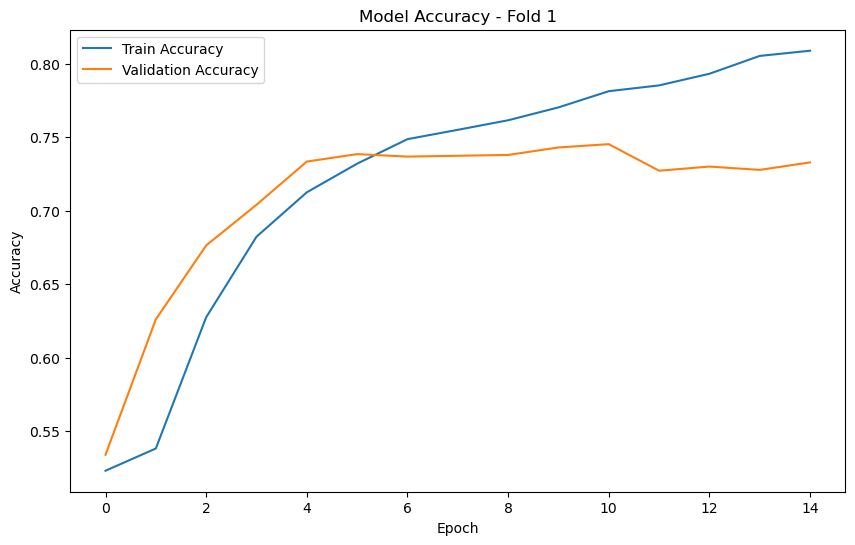

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Fold 1 Validation Results:
Accuracy: 0.7429
Balanced Accuracy: 0.7397
MCC: 0.4912
Sensitivity: 0.8423
Specificity: 0.6371
Confusion Matrix:
TN: 546, FP: 311
FN: 144, TP: 769

Confusion Matrix Format:
[[546 311]
 [144 769]]

New best weights saved! (MCC: 0.4912)

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5018 - loss: 0.7112 - val_accuracy: 0.5791 - val_loss: 0.6830 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5648 - loss: 0.6775 - val_accuracy: 0.6672 - val_loss: 0.6258 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6494 - loss: 0.6297 - val_accuracy: 0.7113 - val_loss: 0.5686 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7111 - loss: 0.5684 - val_accuracy: 0.7435 - val_loss: 0.5318 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7256 - loss: 0.5474 - val_accuracy: 0.7480 - val_loss: 0.5170 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7434 - loss: 0.5300 - val_accuracy: 0.7475 - val_loss: 0.5114 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7602 - loss: 0.5037 - val_

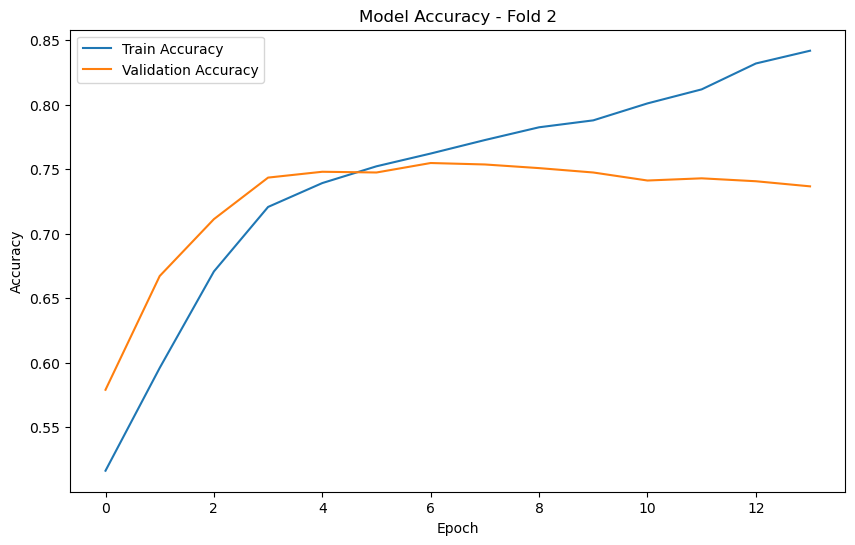

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2 Validation Results:
Accuracy: 0.7508
Balanced Accuracy: 0.7489
MCC: 0.4993
Sensitivity: 0.7831
Specificity: 0.7146
Confusion Matrix:
TN: 596, FP: 238
FN: 203, TP: 733

Confusion Matrix Format:
[[596 238]
 [203 733]]

New best weights saved! (MCC: 0.4993)

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.4986 - loss: 0.7136 - val_accuracy: 0.5051 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5414 - loss: 0.6868 - val_accuracy: 0.6463 - val_loss: 0.6382 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6504 - loss: 0.6237 - val_accuracy: 0.6966 - val_loss: 0.5858 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6997 - loss: 0.5766 - val_accuracy: 0.7169 - val_loss: 0.5648 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7219 - loss: 0.5523 - val_accuracy: 0.7339 - val_loss: 0.5441 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7256 - loss: 0.5299 - val_accuracy: 0.7379 - val_loss: 0.5380 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7504 - loss: 0.5125 - val_

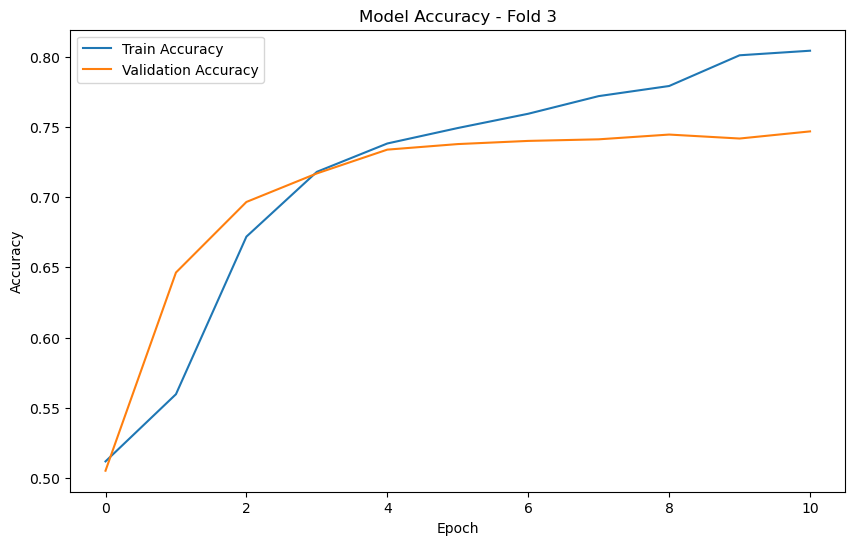

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 3 Validation Results:
Accuracy: 0.7379
Balanced Accuracy: 0.7384
MCC: 0.4767
Sensitivity: 0.7207
Specificity: 0.7561
Confusion Matrix:
TN: 648, FP: 209
FN: 255, TP: 658

Confusion Matrix Format:
[[648 209]
 [255 658]]

Fold 4/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5157 - loss: 0.7112 - val_accuracy: 0.5277 - val_loss: 0.6888 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5503 - loss: 0.6901 - val_accuracy: 0.5831 - val_loss: 0.6767 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5785 - loss: 0.6737 - val_accuracy: 0.6412 - val_loss: 0.6393 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6512 - loss: 0.6346 - val_accuracy: 0.6678 - val_loss: 0.6156 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6830 - loss: 0.6069 - val_accuracy: 0.6763 - val_loss: 0.5943 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7011 - loss: 0.5745 - val_accuracy: 0.7136 - val_loss: 0.5695 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7356 - loss: 0.

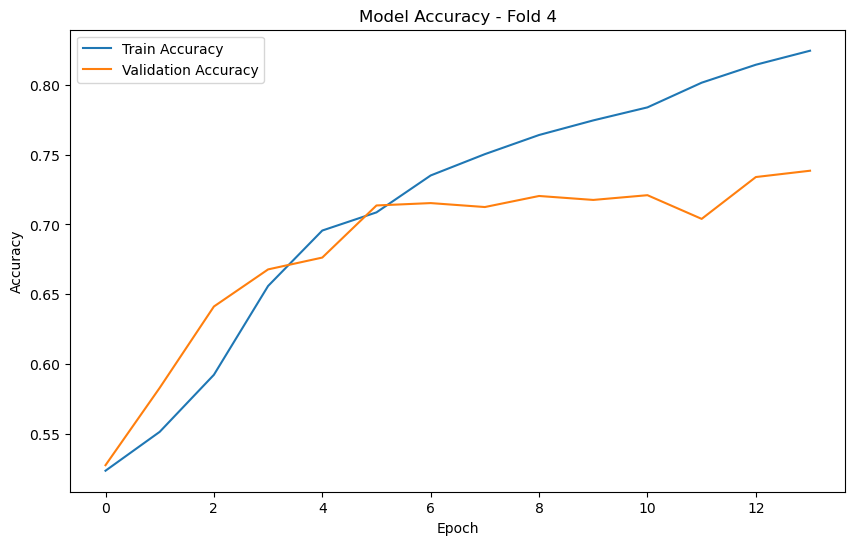

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Fold 4 Validation Results:
Accuracy: 0.7203
Balanced Accuracy: 0.7224
MCC: 0.4478
Sensitivity: 0.6561
Specificity: 0.7888
Confusion Matrix:
TN: 676, FP: 181
FN: 314, TP: 599

Confusion Matrix Format:
[[676 181]
 [314 599]]

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5101 - loss: 0.7212 - val_accuracy: 0.5243 - val_loss: 0.6849 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5762 - loss: 0.6744 - val_accuracy: 0.6610 - val_loss: 0.6277 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6531 - loss: 0.6334 - val_accuracy: 0.6746 - val_loss: 0.6073 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7051 - loss: 0.5838 - val_accuracy: 0.7147 - val_loss: 0.5571 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7297 - loss: 0.5476 - val_accuracy: 0.7322 - val_loss: 0.5393 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7504 - loss: 0.5182 - val_accuracy: 0.7367 - val_loss: 0.5281 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7703 - loss: 0.4967 - val_

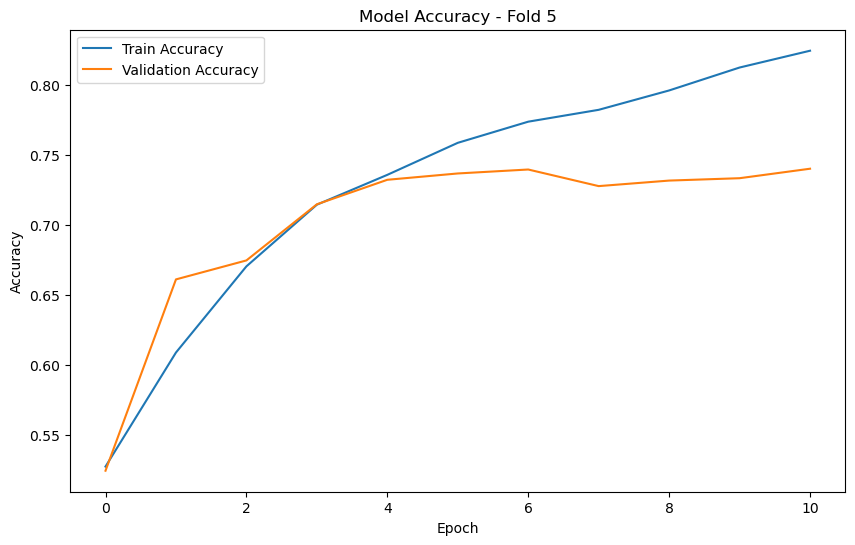

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 5 Validation Results:
Accuracy: 0.7367
Balanced Accuracy: 0.7352
MCC: 0.4725
Sensitivity: 0.7764
Specificity: 0.6940
Confusion Matrix:
TN: 592, FP: 261
FN: 205, TP: 712

Confusion Matrix Format:
[[592 261]
 [205 712]]

Cross-validation Complete

Average Cross-validation Results:
ACC: 0.7377 ± 0.0100
BALANCED_ACC: 0.7369 ± 0.0085
MCC: 0.4775 ± 0.0177
SN: 0.7557 ± 0.0630
SP: 0.7181 ± 0.0521

Final Test Set Evaluation (Best Model)
 1/86 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step

/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Test Set Results:
Accuracy: 0.7223
Balanced Accuracy: 0.7348
MCC: 0.2844
Sensitivity: 0.7500
Specificity: 0.7197
Confusion Matrix:
TN: 1797, FP: 700
FN: 60, TP: 180

Confusion Matrix Format:
[[1797  700]
 [  60  180]]

Continuing without saving model...


In [10]:
if __name__ == "__main__":
    model = train_and_evaluate()

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Fold 1/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.5368 - loss: 0.7069 - val_accuracy: 0.5542 - val_loss: 0.6842 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5345 - loss: 0.6913 - val_accuracy: 0.5695 - val_loss: 0.6722 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5745 - loss: 0.6743 - val_accuracy: 0.6192 - val_loss: 0.6530 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6322 - loss: 0.6492 - val_accuracy: 0.6780 - val_loss: 0.6176 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6847 - loss: 0.5992 - val_accuracy: 0.7458 - val_loss: 0.5458 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7243 - loss: 0.5474 - val_accuracy: 0.7486 - val_loss: 0.5303 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7431 - loss: 0.5286 - val_

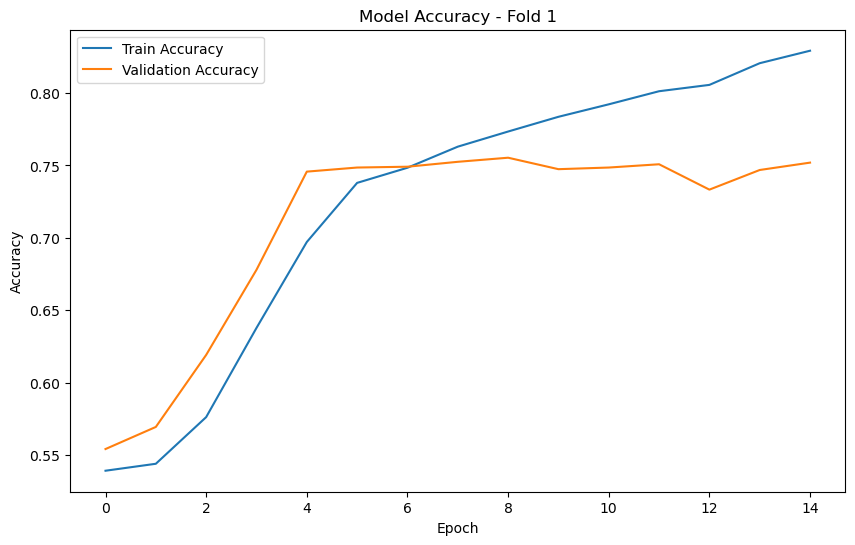

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 1 Validation Results:
Accuracy: 0.7475
Balanced Accuracy: 0.7447
MCC: 0.4981
Sensitivity: 0.8313
Specificity: 0.6581
Confusion Matrix:
TN: 564, FP: 293
FN: 154, TP: 759

Confusion Matrix Format:
[[564 293]
 [154 759]]

New best weights saved! (MCC: 0.4981)

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5347 - loss: 0.7142 - val_accuracy: 0.5989 - val_loss: 0.6779 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5914 - loss: 0.6641 - val_accuracy: 0.6927 - val_loss: 0.5948 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6909 - loss: 0.5885 - val_accuracy: 0.7486 - val_loss: 0.5331 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7260 - loss: 0.5464 - val_accuracy: 0.7475 - val_loss: 0.5140 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7455 - loss: 0.5226 - val_accuracy: 0.7531 - val_loss: 0.5086 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7599 - loss: 0.5059 - val_accuracy: 0.7497 - val_loss: 0.5103 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7636 - loss: 0.4979 - val_

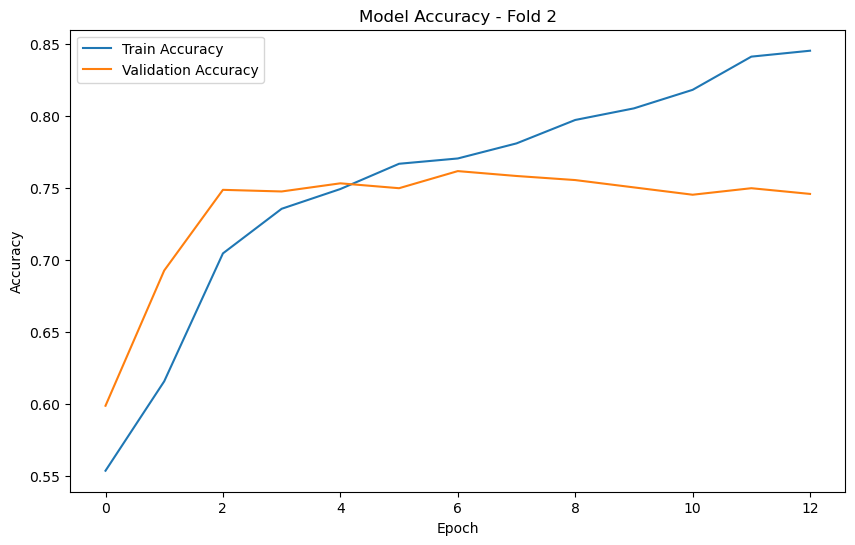

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 2 Validation Results:
Accuracy: 0.7582
Balanced Accuracy: 0.7565
MCC: 0.5141
Sensitivity: 0.7863
Specificity: 0.7266
Confusion Matrix:
TN: 606, FP: 228
FN: 200, TP: 736

Confusion Matrix Format:
[[606 228]
 [200 736]]

New best weights saved! (MCC: 0.5141)

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5299 - loss: 0.7107 - val_accuracy: 0.5729 - val_loss: 0.6835 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5499 - loss: 0.6808 - val_accuracy: 0.5864 - val_loss: 0.6730 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5793 - loss: 0.6741 - val_accuracy: 0.6243 - val_loss: 0.6538 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6305 - loss: 0.6419 - val_accuracy: 0.6621 - val_loss: 0.6194 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6681 - loss: 0.6099 - val_accuracy: 0.6944 - val_loss: 0.5824 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7072 - loss: 0.5714 - val_accuracy: 0.7232 - val_loss: 0.5546 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7303 - loss: 0.5459 - val_

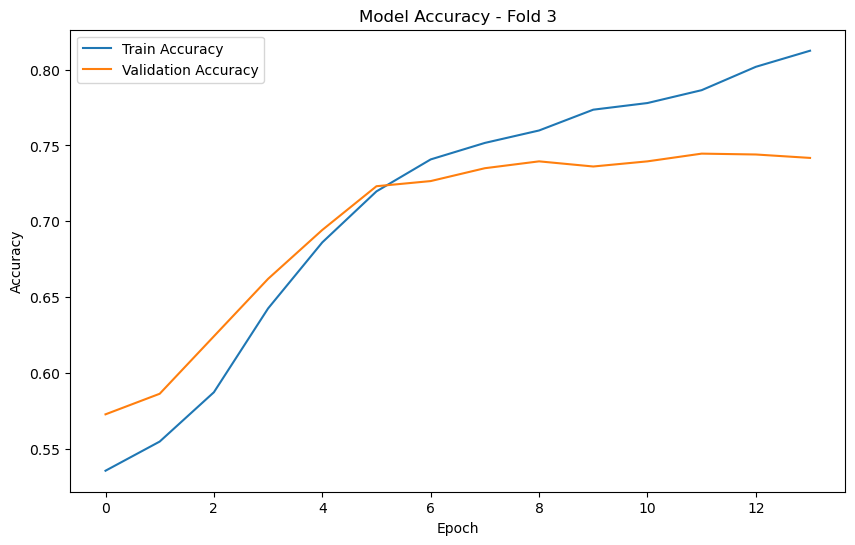

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 3 Validation Results:
Accuracy: 0.7395
Balanced Accuracy: 0.7375
MCC: 0.4798
Sensitivity: 0.8028
Specificity: 0.6721
Confusion Matrix:
TN: 576, FP: 281
FN: 180, TP: 733

Confusion Matrix Format:
[[576 281]
 [180 733]]

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5204 - loss: 0.7094 - val_accuracy: 0.5780 - val_loss: 0.6840 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5674 - loss: 0.6756 - val_accuracy: 0.6514 - val_loss: 0.6263 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6546 - loss: 0.6285 - val_accuracy: 0.7040 - val_loss: 0.5856 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7027 - loss: 0.5744 - val_accuracy: 0.7096 - val_loss: 0.5673 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7410 - loss: 0.5361 - val_accuracy: 0.7243 - val_loss: 0.5534 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7588 - loss: 0.5140 - val_accuracy: 0.7390 - val_loss: 0.5368 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7634 - loss: 0.4988 - val_

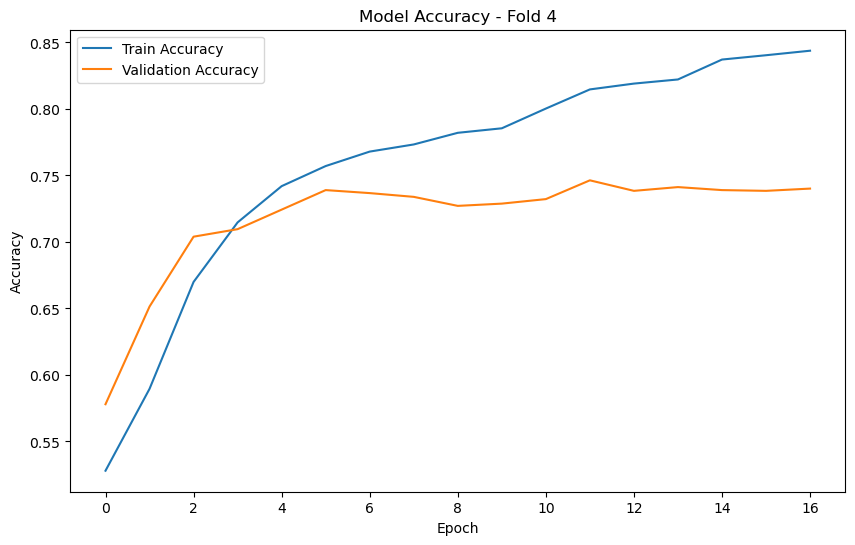

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 4 Validation Results:
Accuracy: 0.7463
Balanced Accuracy: 0.7449
MCC: 0.4923
Sensitivity: 0.7908
Specificity: 0.6989
Confusion Matrix:
TN: 599, FP: 258
FN: 191, TP: 722

Confusion Matrix Format:
[[599 258]
 [191 722]]

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5105 - loss: 0.7211 - val_accuracy: 0.5463 - val_loss: 0.6865 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5624 - loss: 0.6805 - val_accuracy: 0.6006 - val_loss: 0.6627 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6342 - loss: 0.6477 - val_accuracy: 0.6638 - val_loss: 0.6107 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6882 - loss: 0.5988 - val_accuracy: 0.6938 - val_loss: 0.5853 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7125 - loss: 0.5640 - val_accuracy: 0.7186 - val_loss: 0.5513 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7371 - loss: 0.5385 - val_accuracy: 0.7316 - val_loss: 0.5346 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7545 - loss: 0.5115 - val_

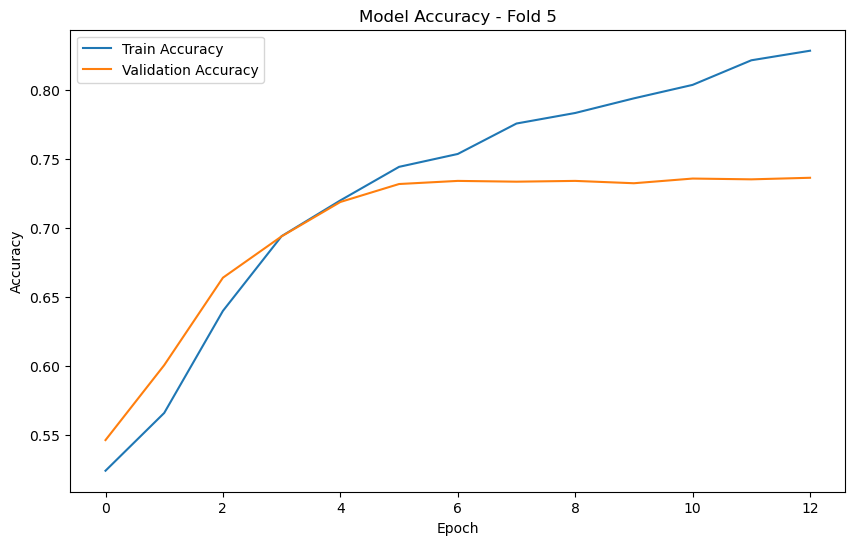

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 5 Validation Results:
Accuracy: 0.7333
Balanced Accuracy: 0.7323
MCC: 0.4656
Sensitivity: 0.7601
Specificity: 0.7046
Confusion Matrix:
TN: 601, FP: 252
FN: 220, TP: 697

Confusion Matrix Format:
[[601 252]
 [220 697]]

Cross-validation Complete

Average Cross-validation Results:
ACC: 0.7450 ± 0.0083
BALANCED_ACC: 0.7432 ± 0.0082
MCC: 0.4900 ± 0.0165
SN: 0.7943 ± 0.0232
SP: 0.6921 ± 0.0243

Final Test Set Evaluation (Best Model)


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Test Set Results:
Accuracy: 0.7304
Balanced Accuracy: 0.7487
MCC: 0.3023
Sensitivity: 0.7708
Specificity: 0.7265
Confusion Matrix:
TN: 1814, FP: 683
FN: 55, TP: 185

Confusion Matrix Format:
[[1814  683]
 [  55  185]]

Continuing without saving model...


In [11]:
if __name__ == "__main__":
    model = train_and_evaluate(struct_window=1)

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Fold 1/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.5253 - loss: 0.7183 - val_accuracy: 0.5842 - val_loss: 0.6760 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5929 - loss: 0.6651 - val_accuracy: 0.6638 - val_loss: 0.6235 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6478 - loss: 0.6334 - val_accuracy: 0.6718 - val_loss: 0.6095 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6723 - loss: 0.6124 - val_accuracy: 0.6983 - val_loss: 0.5943 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6973 - loss: 0.5916 - val_accuracy: 0.6915 - val_loss: 0.5876 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7158 - loss: 0.5660 - val_accuracy: 0.7000 - val_loss: 0.5881 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7268 - loss: 0.5512 - val_

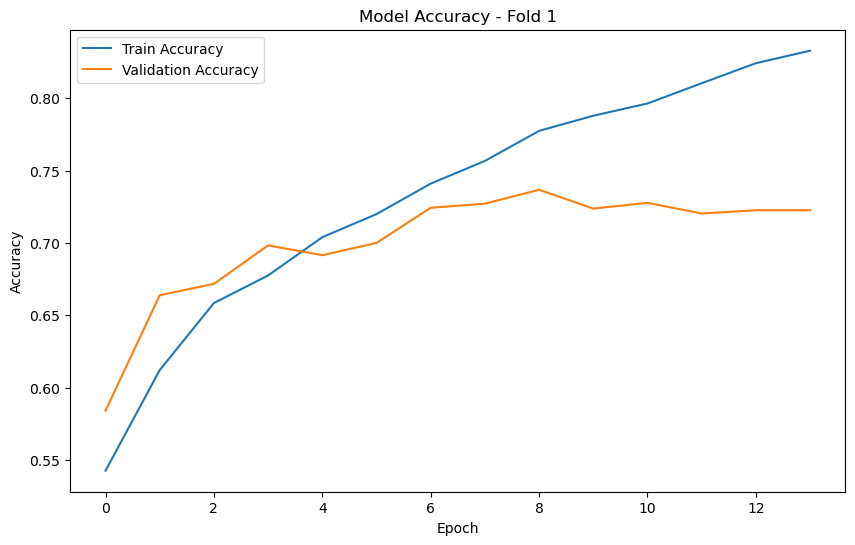

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 1 Validation Results:
Accuracy: 0.7367
Balanced Accuracy: 0.7347
MCC: 0.4740
Sensitivity: 0.7985
Specificity: 0.6709
Confusion Matrix:
TN: 575, FP: 282
FN: 184, TP: 729

Confusion Matrix Format:
[[575 282]
 [184 729]]

New best weights saved! (MCC: 0.4740)

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5101 - loss: 0.7183 - val_accuracy: 0.5814 - val_loss: 0.6826 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5579 - loss: 0.6826 - val_accuracy: 0.5921 - val_loss: 0.6712 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5742 - loss: 0.6756 - val_accuracy: 0.6006 - val_loss: 0.6662 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6032 - loss: 0.6647 - val_accuracy: 0.6384 - val_loss: 0.6317 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6483 - loss: 0.6262 - val_accuracy: 0.6847 - val_loss: 0.5875 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7009 - loss: 0.5813 - val_accuracy: 0.7141 - val_loss: 0.5508 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7266 - loss: 0.5483 - val_

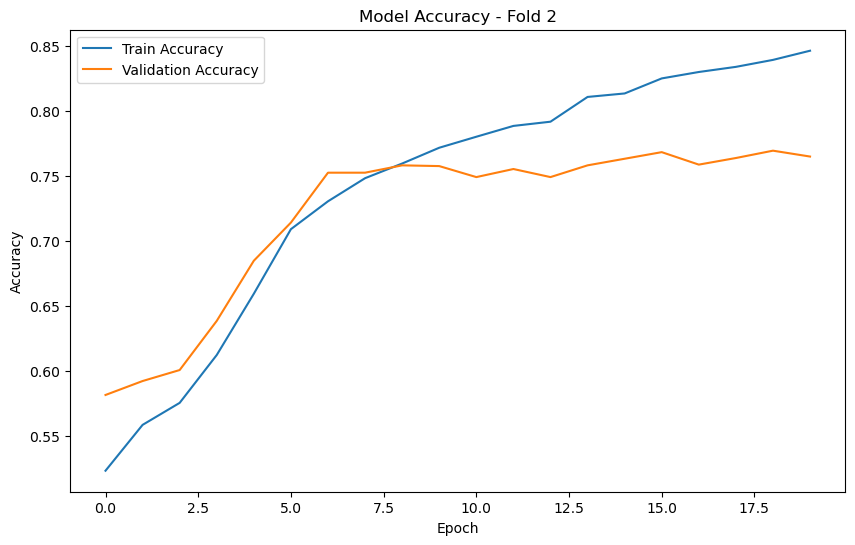

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 2 Validation Results:
Accuracy: 0.7633
Balanced Accuracy: 0.7599
MCC: 0.5246
Sensitivity: 0.8184
Specificity: 0.7014
Confusion Matrix:
TN: 585, FP: 249
FN: 170, TP: 766

Confusion Matrix Format:
[[585 249]
 [170 766]]

New best weights saved! (MCC: 0.5246)

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5182 - loss: 0.7188 - val_accuracy: 0.5706 - val_loss: 0.6827 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5659 - loss: 0.6799 - val_accuracy: 0.5972 - val_loss: 0.6704 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5929 - loss: 0.6636 - val_accuracy: 0.6734 - val_loss: 0.6079 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6927 - loss: 0.5789 - val_accuracy: 0.7260 - val_loss: 0.5533 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7190 - loss: 0.5543 - val_accuracy: 0.7350 - val_loss: 0.5440 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7432 - loss: 0.5294 - val_accuracy: 0.7407 - val_loss: 0.5457 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7461 - loss: 0.5057 - val_

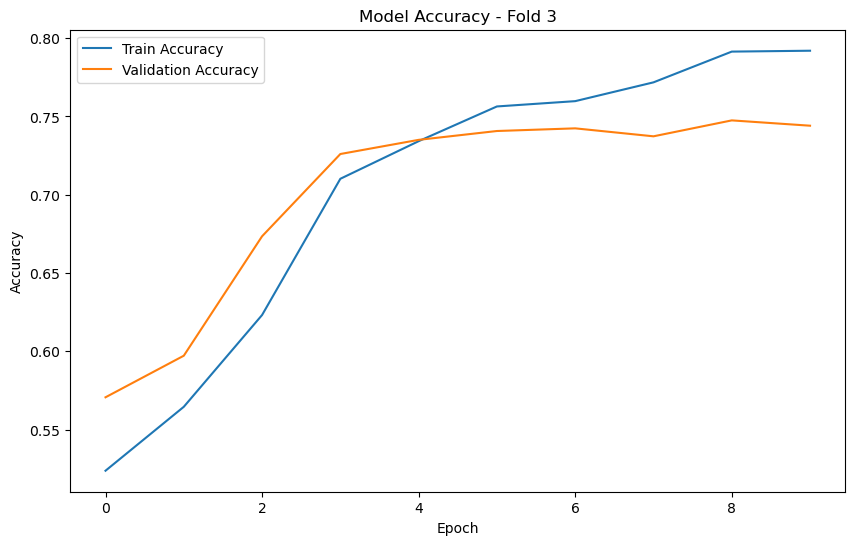

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 3 Validation Results:
Accuracy: 0.7350
Balanced Accuracy: 0.7352
MCC: 0.4701
Sensitivity: 0.7306
Specificity: 0.7398
Confusion Matrix:
TN: 634, FP: 223
FN: 246, TP: 667

Confusion Matrix Format:
[[634 223]
 [246 667]]

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5173 - loss: 0.7651 - val_accuracy: 0.5836 - val_loss: 0.6783 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5827 - loss: 0.6696 - val_accuracy: 0.6531 - val_loss: 0.6325 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6636 - loss: 0.6182 - val_accuracy: 0.6960 - val_loss: 0.5913 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7067 - loss: 0.5796 - val_accuracy: 0.7220 - val_loss: 0.5620 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7356 - loss: 0.5418 - val_accuracy: 0.7305 - val_loss: 0.5481 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7571 - loss: 0.5208 - val_accuracy: 0.7452 - val_loss: 0.5323 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7690 - loss: 0.4993 - val_

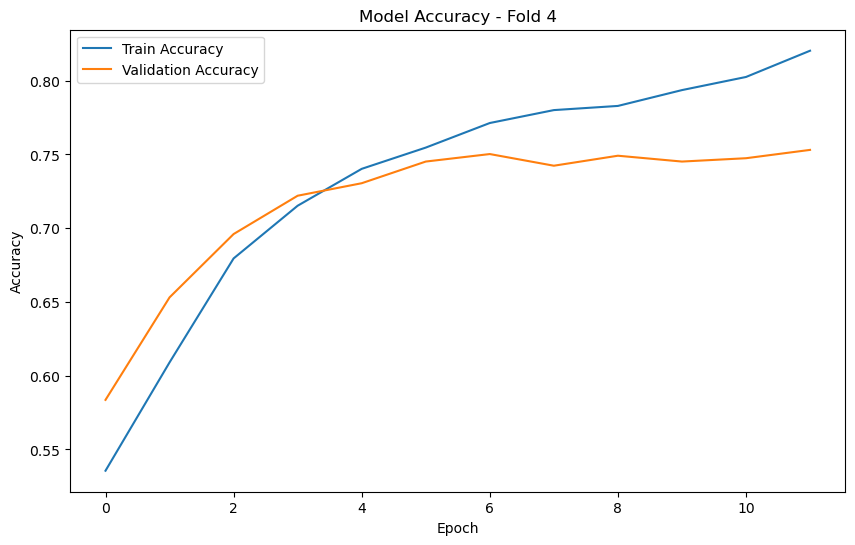

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 4 Validation Results:
Accuracy: 0.7503
Balanced Accuracy: 0.7491
MCC: 0.5000
Sensitivity: 0.7864
Specificity: 0.7118
Confusion Matrix:
TN: 610, FP: 247
FN: 195, TP: 718

Confusion Matrix Format:
[[610 247]
 [195 718]]

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5124 - loss: 0.7342 - val_accuracy: 0.5277 - val_loss: 0.6851 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5703 - loss: 0.6780 - val_accuracy: 0.5497 - val_loss: 0.6767 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6075 - loss: 0.6500 - val_accuracy: 0.6944 - val_loss: 0.5851 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7186 - loss: 0.5687 - val_accuracy: 0.7158 - val_loss: 0.5493 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7320 - loss: 0.5365 - val_accuracy: 0.7322 - val_loss: 0.5382 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7484 - loss: 0.5176 - val_accuracy: 0.7395 - val_loss: 0.5297 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7632 - loss: 0.5014 - val_

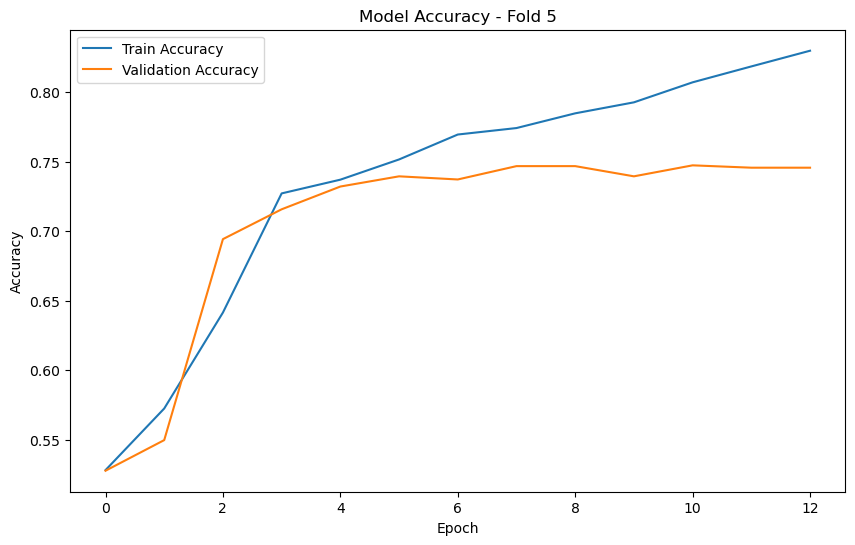

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 5 Validation Results:
Accuracy: 0.7469
Balanced Accuracy: 0.7469
MCC: 0.4935
Sensitivity: 0.7470
Specificity: 0.7468
Confusion Matrix:
TN: 637, FP: 216
FN: 232, TP: 685

Confusion Matrix Format:
[[637 216]
 [232 685]]

Cross-validation Complete

Average Cross-validation Results:
ACC: 0.7464 ± 0.0102
BALANCED_ACC: 0.7452 ± 0.0094
MCC: 0.4925 ± 0.0197
SN: 0.7762 ± 0.0326
SP: 0.7141 ± 0.0274

Final Test Set Evaluation (Best Model)


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Test Set Results:
Accuracy: 0.6997
Balanced Accuracy: 0.7431
MCC: 0.2879
Sensitivity: 0.7958
Specificity: 0.6904
Confusion Matrix:
TN: 1724, FP: 773
FN: 49, TP: 191

Confusion Matrix Format:
[[1724  773]
 [  49  191]]

Continuing without saving model...


In [12]:
if __name__ == "__main__":
    model = train_and_evaluate(struct_window=2)

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Fold 1/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5170 - loss: 0.7148 - val_accuracy: 0.5678 - val_loss: 0.6849 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5610 - loss: 0.6800 - val_accuracy: 0.5718 - val_loss: 0.6743 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5854 - loss: 0.6673 - val_accuracy: 0.6559 - val_loss: 0.6330 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6434 - loss: 0.6276 - val_accuracy: 0.7153 - val_loss: 0.5918 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6949 - loss: 0.5826 - val_accuracy: 0.7288 - val_loss: 0.5489 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7330 - loss: 0.5494 - val_accuracy: 0.7435 - val_loss: 0.5297 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7406 - loss: 0.5290 - val_

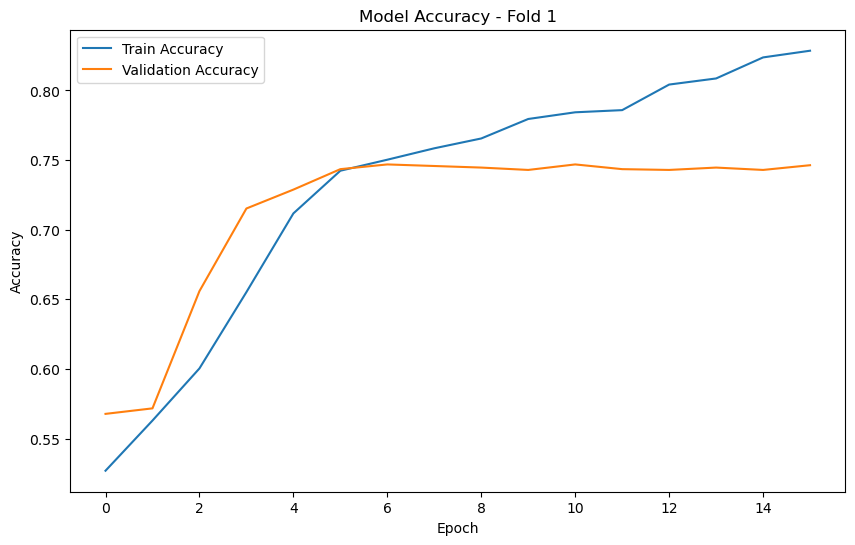

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Fold 1 Validation Results:
Accuracy: 0.7469
Balanced Accuracy: 0.7440
MCC: 0.4978
Sensitivity: 0.8368
Specificity: 0.6511
Confusion Matrix:
TN: 558, FP: 299
FN: 149, TP: 764

Confusion Matrix Format:
[[558 299]
 [149 764]]

New best weights saved! (MCC: 0.4978)

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5109 - loss: 0.7148 - val_accuracy: 0.5712 - val_loss: 0.6839 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5716 - loss: 0.6754 - val_accuracy: 0.6362 - val_loss: 0.6305 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6811 - loss: 0.6007 - val_accuracy: 0.7294 - val_loss: 0.5432 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7224 - loss: 0.5529 - val_accuracy: 0.7429 - val_loss: 0.5211 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7443 - loss: 0.5204 - val_accuracy: 0.7531 - val_loss: 0.5078 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7532 - loss: 0.5106 - val_accuracy: 0.7480 - val_loss: 0.5052 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7679 - loss: 0.4926 - val

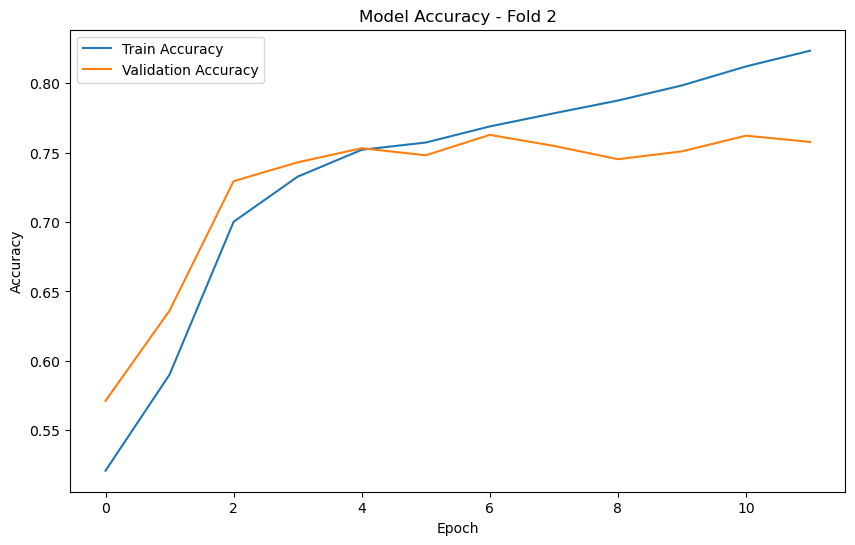

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Fold 2 Validation Results:
Accuracy: 0.7627
Balanced Accuracy: 0.7574
MCC: 0.5261
Sensitivity: 0.8494
Specificity: 0.6655
Confusion Matrix:
TN: 555, FP: 279
FN: 141, TP: 795

Confusion Matrix Format:
[[555 279]
 [141 795]]

New best weights saved! (MCC: 0.5261)

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5174 - loss: 0.7266 - val_accuracy: 0.5791 - val_loss: 0.6814 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5759 - loss: 0.6758 - val_accuracy: 0.6424 - val_loss: 0.6375 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6373 - loss: 0.6397 - val_accuracy: 0.6678 - val_loss: 0.6139 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6769 - loss: 0.6164 - val_accuracy: 0.6797 - val_loss: 0.6021 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6918 - loss: 0.5929 - val_accuracy: 0.6949 - val_loss: 0.5820 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7140 - loss: 0.5640 - val_accuracy: 0.6977 - val_loss: 0.5763 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7370 - loss: 0.5391 - val

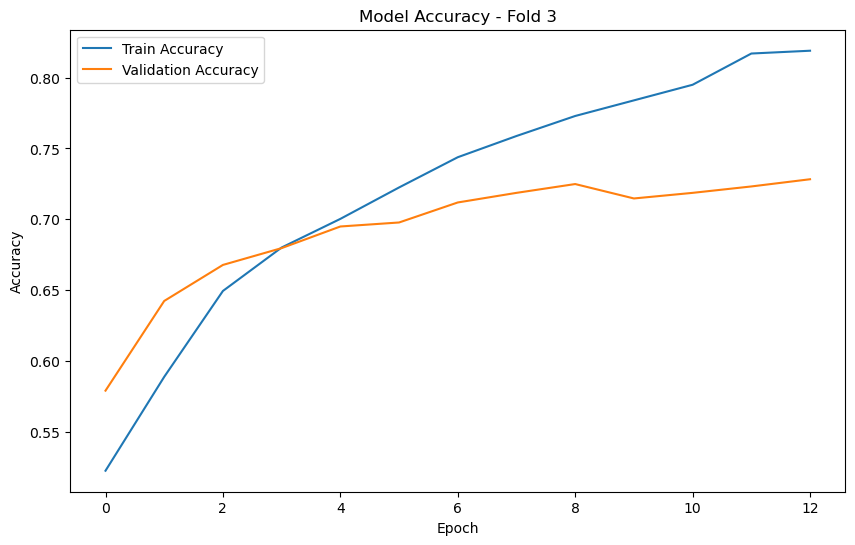

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Fold 3 Validation Results:
Accuracy: 0.7186
Balanced Accuracy: 0.7183
MCC: 0.4367
Sensitivity: 0.7284
Specificity: 0.7083
Confusion Matrix:
TN: 607, FP: 250
FN: 248, TP: 665

Confusion Matrix Format:
[[607 250]
 [248 665]]

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5271 - loss: 0.7229 - val_accuracy: 0.5616 - val_loss: 0.6814 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5560 - loss: 0.6792 - val_accuracy: 0.6458 - val_loss: 0.6351 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6581 - loss: 0.6279 - val_accuracy: 0.7102 - val_loss: 0.5659 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7159 - loss: 0.5655 - val_accuracy: 0.7350 - val_loss: 0.5391 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7400 - loss: 0.5339 - val_accuracy: 0.7401 - val_loss: 0.5267 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7571 - loss: 0.5095 - val_accuracy: 0.7486 - val_loss: 0.5228 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7606 - loss: 0.4999 - val_

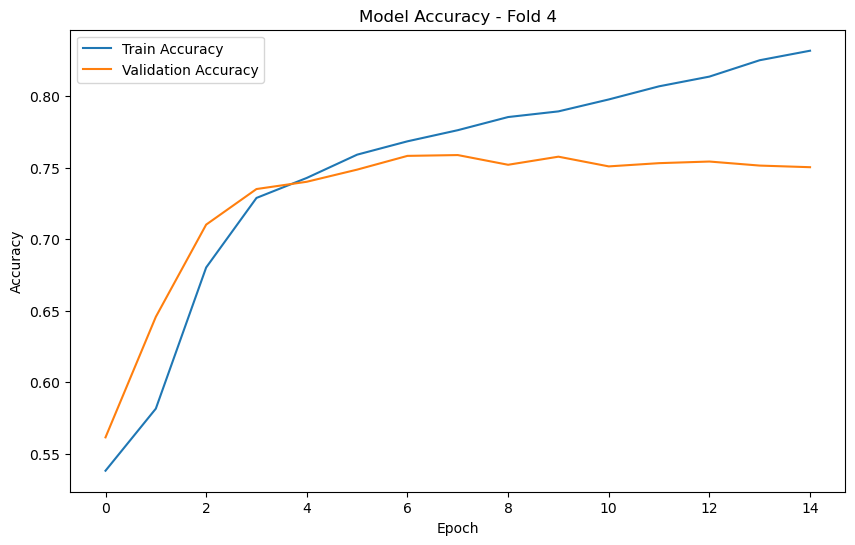

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 4 Validation Results:
Accuracy: 0.7576
Balanced Accuracy: 0.7575
MCC: 0.5149
Sensitivity: 0.7612
Specificity: 0.7538
Confusion Matrix:
TN: 646, FP: 211
FN: 218, TP: 695

Confusion Matrix Format:
[[646 211]
 [218 695]]

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5237 - loss: 0.7167 - val_accuracy: 0.5887 - val_loss: 0.6737 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6013 - loss: 0.6607 - val_accuracy: 0.6706 - val_loss: 0.6251 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6601 - loss: 0.6144 - val_accuracy: 0.6712 - val_loss: 0.6143 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7138 - loss: 0.5763 - val_accuracy: 0.7175 - val_loss: 0.5644 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7271 - loss: 0.5461 - val_accuracy: 0.7266 - val_loss: 0.5516 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7461 - loss: 0.5176 - val_accuracy: 0.7322 - val_loss: 0.5455 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7630 - loss: 0.4932 - val_

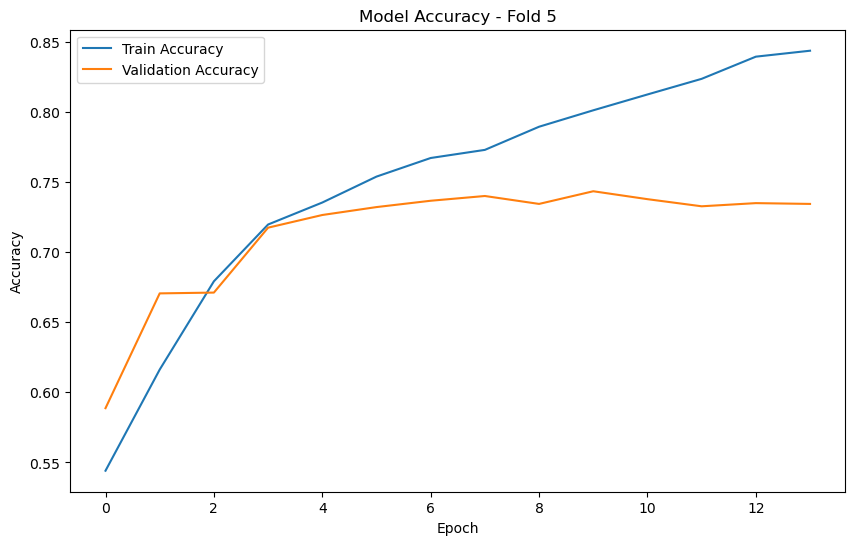

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 5 Validation Results:
Accuracy: 0.7345
Balanced Accuracy: 0.7335
MCC: 0.4679
Sensitivity: 0.7590
Specificity: 0.7081
Confusion Matrix:
TN: 604, FP: 249
FN: 221, TP: 696

Confusion Matrix Format:
[[604 249]
 [221 696]]

Cross-validation Complete

Average Cross-validation Results:
ACC: 0.7441 ± 0.0160
BALANCED_ACC: 0.7421 ± 0.0149
MCC: 0.4887 ± 0.0326
SN: 0.7870 ± 0.0474
SP: 0.6973 ± 0.0363

Final Test Set Evaluation (Best Model)


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Test Set Results:
Accuracy: 0.6712
Balanced Accuracy: 0.7388
MCC: 0.2776
Sensitivity: 0.8208
Specificity: 0.6568
Confusion Matrix:
TN: 1640, FP: 857
FN: 43, TP: 197

Confusion Matrix Format:
[[1640  857]
 [  43  197]]

Continuing without saving model...


In [13]:
if __name__ == "__main__":
    model = train_and_evaluate(struct_window=3)